<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="5">Prevendo a Média Mensal de Vendas - Modelo ARIMA</font></b></strong>

**Modelos de Média Móvel Integrada Auto-Regressiva (ARIMA - Autoregressive Integrated Moving Average Models )**

ARIMA (p, d, q) 

O ARIMA é uma extensão natural da classe de modelos ARMA, que pode reduzir uma série não estacionária a uma série estacionária usando uma sequência de diferenças.

Uma série temporal x(t) é integrada na ordem d se diferenciar a série "d vezes", resultar em uma série discreta de ruído branco.

Uma série temporal x(t) é o modelo ARIMA (p, d, q) se a série diferir d vezes e, em seguida, seguir um processo ARMA (p, q).

Vamos simular um modelo ARIMA para nosso problema de negócio e verificar se conseguimos uma performance melhor do que tivemos com o modelo ARMA.

In [1]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
from pandas import Series

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m

# Imports para modelagem preditiva
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
import scipy
import scipy.stats as scs
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.stattools import jarque_bera
from pmdarima.arima.utils import ndiffs

# Imports para métricas e performance do modelo
import math
from math import sqrt 
import sklearn
from sklearn.metrics import mean_squared_error 

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

#%matplotlib inline

In [2]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

statsmodels.api 0.11.1
scipy           1.4.1
pandas          1.0.5
numpy           1.16.6
matplotlib      3.3.0
statsmodels     0.11.1
sklearn         0.23.1
Data Science Academy


## Definição do Problema de Negócio

Previsão de arrecadação de ICMS.

## Conjunto de Dados

Usaremos conjuntos de dados que mostram a arrecadação de ICMS. Os dados tem registros dos anos de 2010 a 2015.

Será fornecido 1 dataset com 2 colunas, data e arrecadação de icms. 

In [3]:
# Carrega os dados
dataframe = pd.read_csv("Arrecadacao_icms.csv")
dataframe['Data'] = pd.to_datetime(dataframe.Data, format = '%d/%m/%Y')
dataframe = dataframe.set_index('Data')

In [4]:
# Dados
dataframe.head()

,Arrecadacao
Data,
2010-01-01,3299311
2010-02-01,2415158
2010-03-01,2613292
2010-04-01,2533679
2010-05-01,2426702


In [5]:
# Refinamos os dados para o gráfico da série original

# A variável Count é nossa variável target (total de pessoas que usaram transporte)
target = dataframe['Arrecadacao']

In [6]:
# Random seed 
np.random.seed(7)

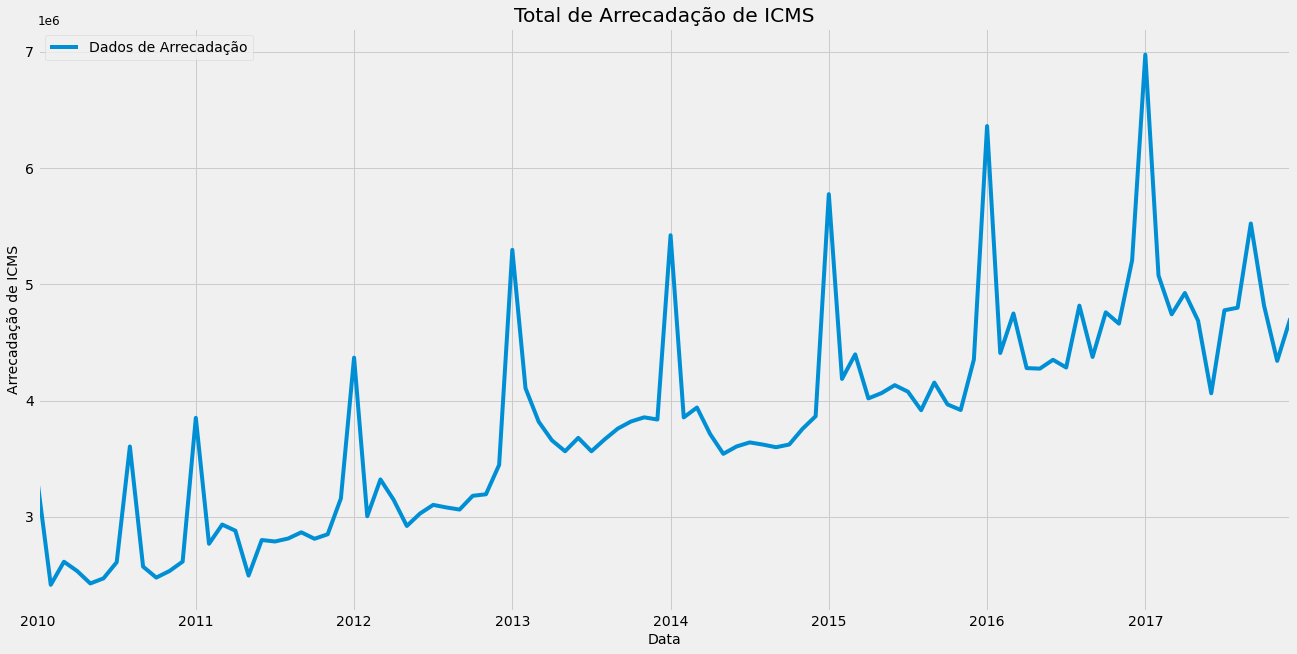

In [7]:
# Plot
target.plot(title = 'Total de Arrecadação de ICMS', fontsize = 14, label = 'Dados de Arrecadação') 
plt.xlabel("Data") 
plt.ylabel("Arrecadação de ICMS") 
plt.legend(loc = 'best') 
plt.show()

## Pré-Processamento

Podemos dividir os dados de treino e validação para treinar e validar a performance do modelo antes de usar os dados de teste.

In [8]:
# Divisão em treino e teste
treino_size = int(len(target) * 0.75)
treino, teste = target[0:treino_size], target[treino_size:]
print(len(treino), len(teste))

72 24


In [9]:
# Aplicando transformação de log
#treino_log = np.log(treino) 

In [10]:
# Você sabe que as transformações aplicadas nos dados de treino devem ser aplicadas nos dados de validação/teste.
#teste_log = np.log(teste)

In [11]:
# Teste ADF
ndiffs(target, test = 'adf') 

0

In [12]:
# Teste KPSS 
ndiffs(target, test = 'kpss')  

1

O Teste ADF indicou d = 0 e o Teste KPSS indicou d = 1.

A escolha é sua meu caro(a) Cientista de Dados.

In [13]:
# Função Para o Cálculo da Acurácia
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 4))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 4))+
                  '\nMAPE das previsões é {}'.format(round(mape, 4))))

## Modelo ARIMA

Antes de criar o modelo ARIMA, vamos aplicar o conceito de Grid Search para encontrar a melhor combinação de valores para os parâmetros p, d e q.

https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMA.html

### Grid Search Para os Parâmetros p, d e q

In [14]:
# Avalia um modelo ARIMA
def avalia_modelo_arima(X, arima_order):
    
    # Prepara os dados
    train_size = int(len(X) * 0.75)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    # Previsões
    predictions = list()
    
    # Loop
    for t in range(len(test)):
        model = ARIMA(history, order = arima_order)
        model_fit = model.fit(method = 'mle', disp = 0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
      
    # Calcula o erro do modelo
    error = mean_squared_error(test, predictions)
    return error

In [15]:
# Avalia as combinações de valores p, d e q para um modelo ARIMA
def avalia_melhor_arima(dataset, p_values, d_values, q_values):
    
    # Ajusta o tipo dos dados
    dataset = dataset.astype('float32')
    
    # Define variáveis de controle
    best_score, best_cfg = float("inf"), None
    
    # Loop pelos valores de p, d e q
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = avalia_modelo_arima(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s   MSE = %.4f   RMSE = %.4f'% (order, mse, np.sqrt(mse)))
                except:
                    continue

    print('\nMelhor Modelo ARIMA%s   MSE = %.4f   RMSE = %.4f' % (best_cfg, best_score, np.sqrt(best_score)))

In [16]:
# Valores para o grid
p_values = [0, 1, 2, 3, 4]
d_values = [0, 1] 
q_values = [0, 1, 2] 

In [17]:
# Testando o melhor valor de p, d e q em os dados de treino
#warnings.simplefilter("ignore")

avalia_melhor_arima(treino.values, p_values, d_values, q_values)

ARIMA(0, 0, 0)   MSE = 703629407073.2727   RMSE = 838826.2079
ARIMA(0, 0, 1)   MSE = 503789107072.2549   RMSE = 709781.0276
ARIMA(0, 0, 2)   MSE = 397740013480.0090   RMSE = 630666.3250
ARIMA(0, 1, 0)   MSE = 378232813965.2434   RMSE = 615006.3528


C:\Users\Guto\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Guto\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(0, 1, 1)   MSE = 255281727721.7425   RMSE = 505254.1219
ARIMA(0, 1, 2)   MSE = 245027017786.3265   RMSE = 495002.0382
ARIMA(1, 0, 0)   MSE = 360522108077.2175   RMSE = 600434.9324
ARIMA(1, 0, 1)   MSE = 270361408130.8500   RMSE = 519962.8911
ARIMA(1, 1, 0)   MSE = 292084239305.6658   RMSE = 540448.1837
ARIMA(1, 1, 1)   MSE = 241923035302.8610   RMSE = 491856.7223


C:\Users\Guto\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Guto\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Guto\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(2, 0, 0)   MSE = 297192795379.1703   RMSE = 545153.9190
ARIMA(2, 0, 1)   MSE = 264806397975.4306   RMSE = 514593.4298
ARIMA(2, 0, 2)   MSE = 270566326252.8111   RMSE = 520159.9045
ARIMA(2, 1, 0)   MSE = 288763611700.1678   RMSE = 537367.2968
ARIMA(2, 1, 1)   MSE = 238261685152.2794   RMSE = 488120.5642


C:\Users\Guto\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Guto\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(3, 0, 0)   MSE = 292370145928.0035   RMSE = 540712.6279
ARIMA(3, 0, 1)   MSE = 284345831295.9332   RMSE = 533240.8755
ARIMA(3, 0, 2)   MSE = 253829567631.4729   RMSE = 503815.0133
ARIMA(3, 1, 0)   MSE = 282813771934.0609   RMSE = 531802.3805
ARIMA(3, 1, 1)   MSE = 242453539097.4317   RMSE = 492395.7139


C:\Users\Guto\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Guto\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA(4, 0, 0)   MSE = 289713775781.3201   RMSE = 538250.6626
ARIMA(4, 0, 1)   MSE = 261021682714.8431   RMSE = 510902.8114
ARIMA(4, 0, 2)   MSE = 252171361505.6901   RMSE = 502166.6671
ARIMA(4, 1, 0)   MSE = 274105650201.6360   RMSE = 523551.0006
ARIMA(4, 1, 1)   MSE = 254013124164.6086   RMSE = 503997.1470


C:\Users\Guto\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Guto\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Guto\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)



Melhor Modelo ARIMA(2, 1, 1)   MSE = 238261685152.2794   RMSE = 488120.5642


C:\Users\Guto\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


As mensagens de warning acima indicam que as algumas combinações testadas não fazem o modelo nem mesmo convergir.

De acordo com o resultado, os melhores valores são: order = (2,1,1). Vamos então criar o modelo com (2,0,1).

## Vamos fazer previsões com o modelo Forecast usando 'ARIMA'

In [18]:
# Modelo
modelo_AR = ARIMA(treino, order = (2, 1, 1))

C:\Users\Guto\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\Guto\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [19]:
# Treinamento
#modelo_v1 = modelo_AR.fit(disp = -1)  
modelo_v1 = modelo_AR.fit(method = 'mle', disp = False)

In [20]:
modelo_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Arrecadacao   No. Observations:                   71
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1029.674
Method:                           mle   S.D. of innovations         469097.988
Date:                Sat, 22 Aug 2020   AIC                           2069.348
Time:                        14:13:15   BIC                           2080.661
Sample:                    02-01-2010   HQIC                          2073.847
                         - 12-01-2015                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2.465e+04   3485.200      7.073      0.000    1.78e+04    3.15e+04
ar.L1.D.Arrecadacao     0.1712      0.121      1.418      0.156      -0.065       0.408
ar.L2.D.Arrecadacao     0.0768      0.121      0.636      0.525      -0.160       0.314
ma.L1.D.Arrecadacao    -0.9967      0.041    -24.583      0.000      -1.076      -0.917
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.6618           +0.0000j            2.6618            0.0000
AR.2           -4.8906           +0.0000j            4.8906            0.5000
MA.1            1.0033           +0.0000j            1.0033            0.0000
-----------------------------------------------------------------------------
"""

In [21]:
# Forecast
# O parâmetro alfa representa o intervalo de confiança, nesse caso, 95%
fc, se, conf = modelo_v1.forecast(len(teste), alpha = 0.05) 

# Precisamos criar um dataframe para criar o Plot
fc_series = pd.Series(fc, index = teste.index)
limite_inferior = pd.Series(conf[:, 0], index = teste.index)
limite_superior = pd.Series(conf[:, 1], index = teste.index)

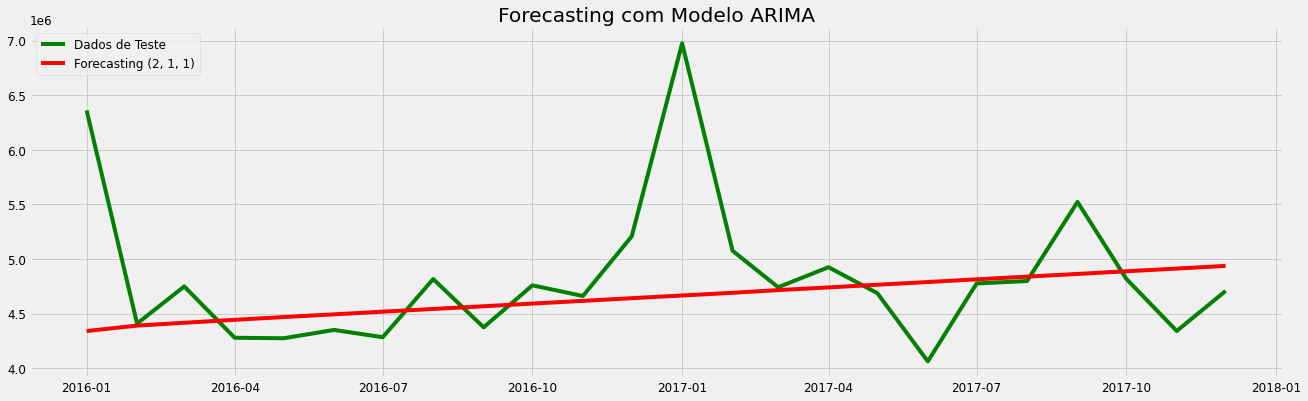

In [22]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(fc_series, label = 'Forecasting (2, 1, 1)', color = 'red')
plt.title('Forecasting com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [23]:
# Calculando a performance
arima_results = performance(teste, fc_series)
#arima_results

MSE das previsões é 485953788409.7614
RMSE das previsões é 697103.8577
MAPE das previsões é 7.4714


## Vamos fazer previsões com o modelo usando 'ARIMA'

In [24]:
# Cria o modelo com os dados de treino
modelo_arima = ARIMA(treino, order = (2,0,1))

C:\Users\Guto\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [25]:
# Treina o modelo
#modelo_arima_fit = modelo_arima.fit(disp = -1)  
modelo_arima_fit = modelo_arima.fit(method = 'mle', disp = False)

In [26]:
# Sumário do modelo
modelo_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            Arrecadacao   No. Observations:                   72
Model:                     ARMA(2, 1)   Log Likelihood               -1048.215
Method:                           mle   S.D. of innovations         504251.500
Date:                Sat, 22 Aug 2020   AIC                           2106.431
Time:                        14:13:15   BIC                           2117.814
Sample:                    01-01-2010   HQIC                          2110.962
                         - 12-01-2015                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              3.469e+06   4.62e+05      7.515      0.000    2.56e+06    4.37e+06
ar.L1.Arrecadacao     1.1429      0.154      7.429      0.000       0.841       1.444
ar.L2.Arrecadacao    -0.1589      0.146     -1.087      0.277      -0.445       0.128
ma.L1.Arrecadacao    -0.8116      0.093     -8.726      0.000      -0.994      -0.629
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0194           +0.0000j            1.0194            0.0000
AR.2            6.1752           +0.0000j            6.1752            0.0000
MA.1            1.2321           +0.0000j            1.2321            0.0000
-----------------------------------------------------------------------------
"""

> Observe a métrica AIC (Akaike Information Criterion). Esse valor deve ser o menor possível para uma boa performance do modelo.

## Previsão com o modelo treinado - Predict

In [27]:
# Predict
# Previsões com o modelo (passamos somente as datas e o modelo prevê os valores)
arima_predict = modelo_arima_fit.predict(start = pd.to_datetime('2016-01-01'), 
                                         end = pd.to_datetime('2017-12-01'),
                                         dynamic = False)

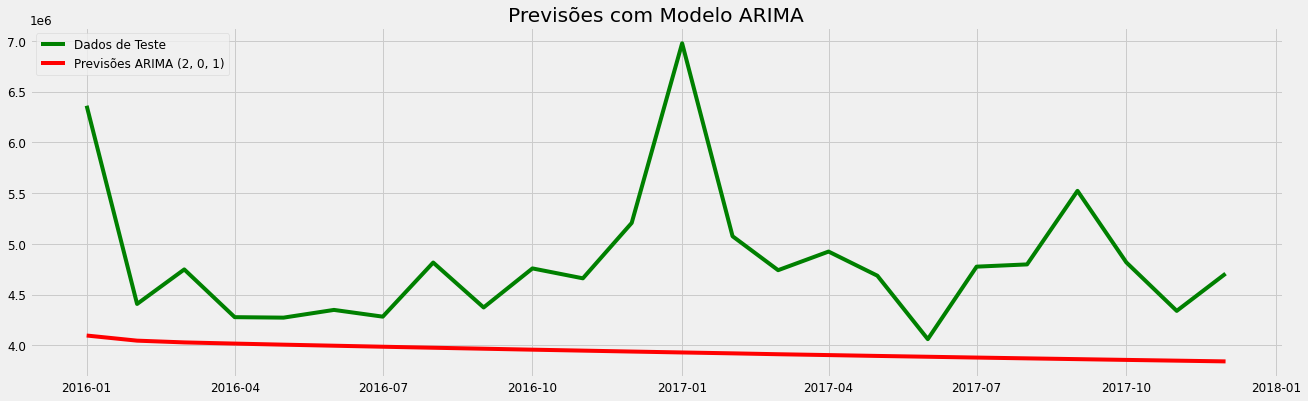

In [28]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(arima_predict, label = 'Previsões ARIMA (2, 0, 1)', color = 'red')
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

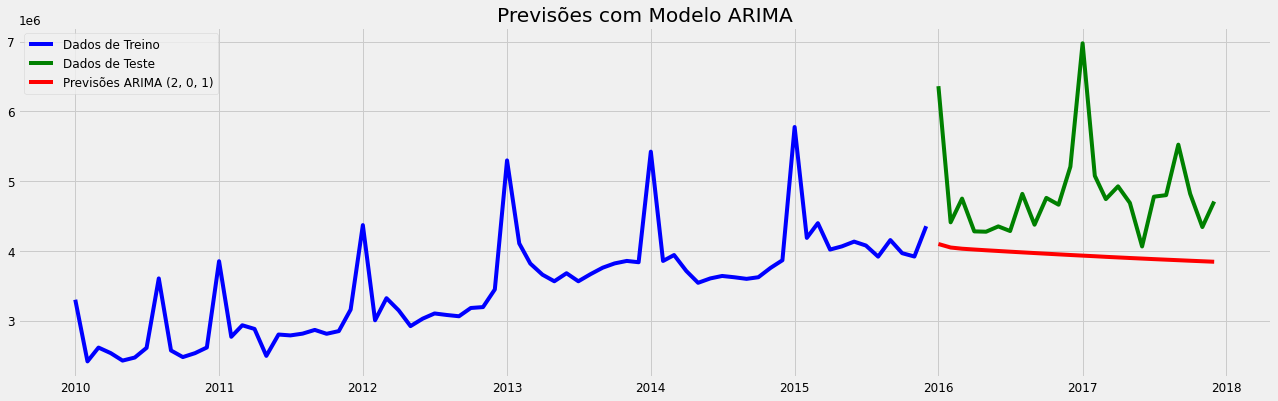

In [29]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(treino, label = 'Dados de Treino', color = 'blue')
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(arima_predict, label = 'Previsões ARIMA (2, 0, 1)', color = 'red')
plt.title('Previsões com Modelo ARIMA')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

In [30]:
# Calculando a performance
arima_results = performance(teste, arima_predict)
#arima_results

MSE das previsões é 1208661441070.6902
RMSE das previsões é 1099391.3958
MAPE das previsões é 17.1869


Vamos executar alguns diagnósticos para avaliar o modelo.

> Os resíduos do modelo devem ser normalmente distribuídos. Vamos checar com o teste jarque_bera.

In [31]:
# Teste
score, pvalue, _, _ = jarque_bera(modelo_arima_fit.resid)

# Resultado
if pvalue < 0.05:
    print ('\n pvalue = %.8f  -  Os resíduos podem não ser normalmente distribuídos.' % (pvalue))
else:
    print ('\n pvalue = %.8f  -  Os resíduos parecem normalmente distribuídos.' % (pvalue))


 pvalue = 0.00000000  -  Os resíduos podem não ser normalmente distribuídos.


In [32]:
# Teste de Ljung-Box
resultado_teste = sms.diagnostic.acorr_ljungbox(modelo_arima_fit.resid, lags = [30], boxpierce = False)
print('Valor-p =', resultado_teste[1])

Valor-p = [1.03289483e-05]


Observe que o valor-p é menor que 0,05, o que indica que os resíduos não são independentes no nível de 95% e, portanto, um modelo ARIMA (2,0,1) não fornece um bom ajuste do modelo.

Como estamos até agora:

- Modelo 15 --> Modelo ARMA (12,9) - AIC = 2044.48 e RMSE = 706415.3914
- Modelo 16 --> Modelo ARIMA (2,1,1) - AIC = 2106,43 e RMSE = 1099391.3958

Com o modelo ARIMA conseguimos reduzir o erro total do modelo, embora o AIC tenha aumentado um pouco. 

O modelo ARIMA consegue um ajuste aos dados, mas não é muito melhor que o modelo ARMA.

Vamos ver o que conseguimos com um modelo mais avançado, o SARIMA. Na próxima aula. 

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim